In [9]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_auc_score, classification_report, zero_one_loss
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.linear_model import SGDClassifier  # For decision boundary visualization
from sklearn.linear_model import LogisticRegression  # For main logistic regression models
from sklearn.multioutput import MultiOutputClassifier

import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Plot configuration
plot_kwargs = {'cmap': 'jet',     # color scheme for decision boundary
               'response_method': 'predict',
               'plot_method': 'pcolormesh',
               'shading': 'auto',
               'alpha': 0.5,
               'grid_resolution': 100}

# Set random seed for reproducibility
seed = 1234
np.random.seed(seed)

In [10]:
# Load the data
train = pd.read_csv("train.csv")
X = train['comment_text'].fillna('')  # Replace missing text with an empty string
y = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

# Text Vectorization
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1, 2))
X_tfidf = vectorizer.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=seed)

# Standardize the features for visualization
scaler = StandardScaler(with_mean=False)  # with_mean=False since TF-IDF is sparse
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression Model for each label
multi_log_reg = MultiOutputClassifier(LogisticRegression(max_iter=200, C=1, penalty='l2', class_weight='balanced'))
multi_log_reg.fit(X_train_scaled, y_train)

MultiOutputClassifier(estimator=LogisticRegression(C=1, class_weight='balanced',
                                                   max_iter=200))

In [13]:
# Evaluate the model
y_pred = multi_log_reg.predict(X_test_scaled)
y_proba = multi_log_reg.predict_proba(X_test_scaled)

# Calculate ROC-AUC score for each label
roc_auc_scores = [roc_auc_score(y_test.iloc[:, i], y_proba[i][:, 1]) for i in range(len(y.columns))]

# Print ROC-AUC for each label
for i, label in enumerate(y.columns):
    print(f'ROC-AUC for {label}: {roc_auc_scores[i]:.4f}')

# Print classification report
print("\nClassification Report (for each label):\n")
print(classification_report(y_test, y_pred, target_names=y.columns, zero_division=0))

ROC-AUC for toxic: 0.9263
ROC-AUC for severe_toxic: 0.8879
ROC-AUC for obscene: 0.9263
ROC-AUC for threat: 0.9073
ROC-AUC for insult: 0.9127
ROC-AUC for identity_hate: 0.8544

Classification Report (for each label):

               precision    recall  f1-score   support

        toxic       0.56      0.78      0.65      3002
 severe_toxic       0.14      0.46      0.21       297
      obscene       0.50      0.76      0.60      1612
       threat       0.23      0.40      0.29        91
       insult       0.41      0.69      0.51      1495
identity_hate       0.12      0.42      0.18       277

    micro avg       0.43      0.72      0.54      6774
    macro avg       0.32      0.58      0.41      6774
 weighted avg       0.47      0.72      0.56      6774
  samples avg       0.06      0.07      0.06      6774



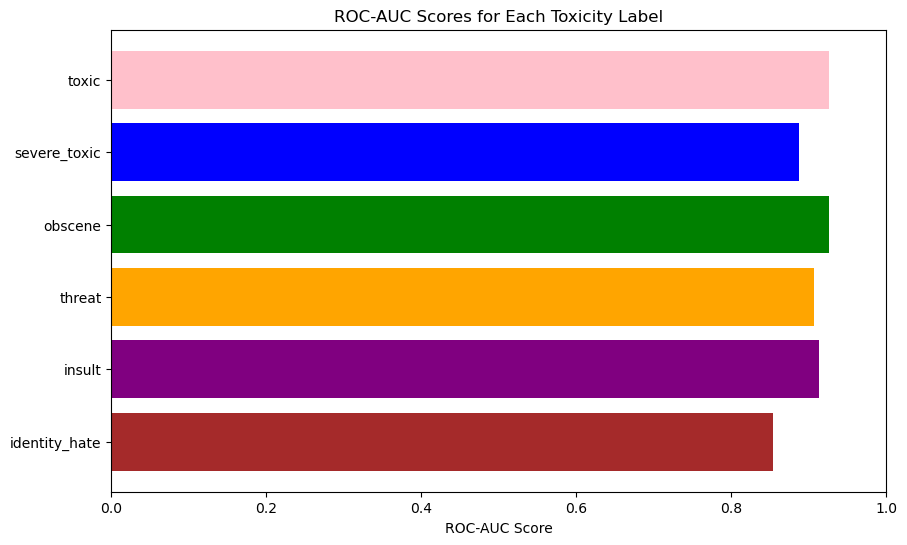

In [17]:
# Define a list of colors (one for each label)
colors = ['pink', 'blue', 'green', 'orange', 'purple', 'brown']

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.barh(y.columns, roc_auc_scores, color=colors)  # Use the predefined colors
plt.xlabel('ROC-AUC Score')
plt.title('ROC-AUC Scores for Each Toxicity Label')
plt.xlim(0, 1)  # ROC-AUC scores range from 0 to 1
plt.gca().invert_yaxis()  # Put the most important label at the top
plt.show()